# EPMT - Data Migration Study

## Background

Data migration operations constitute operations that either move or copy data
from one location to another. Often, hierarchical storage management (HSM) requires
prefectching data from auxillary storage to a local (more expensive) storage prior
to operations on the data. We also include archiving, unarchiving and deletion in
data migration operations. 

In this study we analyze a large collection of post-processing jobs and determine
the fraction of time spent on data migration operations in relation to the total
runtime of the jobs.

## Data used for the study
The jobs span `439` jobids falling between `4839165` to `4899603`. These were provided
by GFDL in a database dump on 05/06/2020.

In [38]:
# this is the main API module
import epmt_query as eq

# we need maptplotlib and seaborn for plots
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [2]:
# make sure we are using a recent version
eq.version()

(3, 8, 17)

We have a curated list of data-movement operations provided by GFDL.

In [3]:
DM_OPS = ['op:hsmput', 'op:dmget', 'op:untar', 'op:mv', 'op:dmput', 'op:hsmget', 'op:rm', 'op:cp']

We will use the powerful API call `ops_costs`, which determines the time spent in operations, and also
computes it as a fraction of total job times. We will use all the jobs in the database. At present,
the database only contains the `493` jobs from the GFDL database dump.

`ops_costs` takes the jobs, the tags defining the operations to measure, and the metric of choice. It allows measuring `duration` and `cpu_time`. We will use `duration` as the metric as we want to measure wall-clock time. 

For `duration` we take care not to double-count overlapping processes. So, the computation is decidedly slower than for a `metric` like `cpu_time`, where we can use database operations to aggregate counts across processes in a job.
In our study, the call took around 30 minutes to process the 500 jobs in the database when using `duration` as
the `metric`, while the same call took just 5 minutes with `cpu_time` as the metric.

In [4]:
(ops_percent, ops_df, total_job_time, ops_df_agg_by_job) = eq.ops_costs(jobs = [], tags = DM_OPS, metric = 'duration')

In [6]:
ops_percent, total_job_time

(67.102, 1693709129331.0)

So, across all the jobs, approximately two-thirds of the wallclock time was spent in data movement.
That's quite surprising!

The dataframe below shows the aggregated metrics for each operation. Since, there were `493` jobs, and
8 operations per job (at most), the number of rows is excessive, and we will prune the output to see
the top rows by `duration`. As you can see the `hsmget` operation dominates.

In [11]:
# only showing the top-10 rows (sorted by duration) to keep the output concise
ops_df.sort_values('duration', ascending=False)[:10]

,jobid,tags,duration,invol_ctxsw,cutime,usertime,delayacct_blkio_time,minflt,syscr,cstime,...,wchar,cmajflt,read_bytes,write_bytes,cancelled_write_bytes,systemtime,rchar,rssmax,syscw,time_waiting
1629,4877796,{'op': 'hsmget'},5.991662e+09,150659,7301010000,1505831404,0,108639976,6642171,1438630000,...,236510765452,154,44265472,236524785664,2203648,351444044,17278261142,561993688,1770198,385047105143
1086,4877801,{'op': 'hsmget'},5.894431e+09,53144,418880000,137904099,0,25418755,1661079,208170000,...,1007858912,59,15093760,1026715648,983040,72685237,4223901197,154623380,143794,67536612515
399,4877800,{'op': 'hsmget'},5.869572e+09,201317,1348660000,456883688,0,93841525,6132218,726300000,...,10466363776,151,53288960,10479132672,1572864,272195790,14958421945,474603612,769743,297514203592
1593,4877794,{'op': 'hsmget'},5.761952e+09,68610,1715600000,404586808,0,44048091,2701606,474470000,...,46124427144,193,27623424,46126432256,974848,127346902,7042397906,232054124,509709,156860914293
861,4877795,{'op': 'hsmget'},5.761742e+09,36872,676430000,174215699,0,22959654,1414656,191490000,...,14902659782,5,3112960,14906953728,741376,57361253,3806707592,130707524,198226,84506743129
91,4877811,{'op': 'hsmget'},5.738425e+09,6576,154730000,37587931,0,4262525,261153,37770000,...,4099802177,165,17035264,4101029888,81920,11416970,676696943,21799832,46837,15416084411
1587,4877821,{'op': 'hsmget'},5.733998e+09,27244,1341010000,273989583,0,19087056,1171275,241250000,...,43815179708,5,2982912,43817668608,491520,59533865,3067308678,103658996,293226,64547018766
192,4877819,{'op': 'hsmget'},5.731696e+09,6064,584940000,108757141,0,4203989,256854,102600000,...,21119472978,17,4767744,21121040384,81920,21883353,666025293,21553352,111677,15224254832
302,4877820,{'op': 'hsmget'},5.728264e+09,45586,438020000,162969743,0,34286138,2096893,166370000,...,1108489744,9,11018240,1115512832,737280,63996478,5453323380,179413004,251377,121154712775
1467,4877798,{'op': 'hsmget'},5.727027e+09,34859,672460000,179550812,0,18614381,1173567,259490000,...,10056352660,24,12009472,10058092544,487424,83374346,3070554405,102461044,164524,95283648075


The above dataframe shows the metrics for each operation. The `ops_costs` API call also returns another
dataframe that groups the operations in a job, so one can see at glance the total data-movement time
for each (and as a percentage of total job duration). Since we have too many jobs, we will restrict
the listing to the top few.

In [14]:
# top-20 rows shown
ops_df_agg_by_job.sort_values('dm_duration', ascending=False)[:20]

,jobid,dm_duration,job_duration,dm_duration%
240,4868943,8.703285e+09,1.849700e+10,47.0
274,4877796,8.343098e+09,1.468037e+10,57.0
206,4884950,8.118046e+09,2.326301e+10,35.0
232,4839167,7.900293e+09,2.040303e+10,39.0
178,4887609,7.370950e+09,1.772124e+10,42.0
173,4893807,7.306170e+09,1.677814e+10,44.0
268,4877794,7.230925e+09,1.065763e+10,68.0
74,4864953,7.225494e+09,1.834067e+10,39.0
267,4877821,6.821228e+09,1.031938e+10,66.0
357,4865042,6.741912e+09,1.713411e+10,39.0


The plot below shows a histogram of the `dm_duration%`, with the vertical axis
showing a count of the number of jobs in each bin.

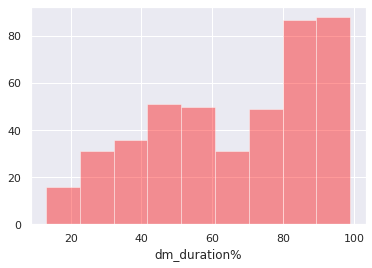

In [37]:
sns.distplot(ops_df_agg_by_job['dm_duration%'], kde=False, color='red')

What is most striking is that for more than 160 jobs (~ 30% of the jobs), the data migration operations took more than `80%` of the job time! The other aspect to note is that the distribution seems bimodal. That might be because of HSM, which causes the initial jobs to take the bulk of the hit in data movement, while later jobs take far less. 